In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
BASE_PATH = '/content/drive/MyDrive/Model'
os.makedirs(BASE_PATH, exist_ok=True)

In [ ]:
data_path = "/content/drive/MyDrive/Model/new_combined_without_states.csv"   # <-- CHANGE this path to your CSV location
output_dir = "/content/drive/MyDrive/Model/lstm_saved"   # where model + scalers will be saved
os.makedirs(output_dir, exist_ok=True)

In [ ]:
df = pd.read_csv(data_path)

In [ ]:
df

,datetime,DELHI,temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),is_holiday,hour,day,month,year,dayofweek,is_weekend
0,2022-01-01 05:30:00,1944.275833,6.51,4.99,0.90,1.86,276.73,0.00,0.0,1,5,1,1,2022,5,1
1,2022-01-01 06:30:00,2576.447500,6.40,5.09,0.91,1.88,279.22,0.00,0.0,1,6,1,1,2022,5,1
2,2022-01-01 07:30:00,3373.065833,6.64,5.14,0.90,1.81,283.98,0.00,0.0,1,7,1,1,2022,5,1
3,2022-01-01 08:30:00,3923.857500,7.03,5.08,0.87,2.03,289.73,0.00,0.0,1,8,1,1,2022,5,1
4,2022-01-01 09:30:00,4235.902500,8.47,5.93,0.84,1.51,296.47,0.01,0.0,1,9,1,1,2022,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,2023-12-31 18:30:00,3683.451667,12.58,10.08,0.85,1.62,41.80,0.25,0.0,0,18,31,12,2023,6,1
16773,2023-12-31 19:30:00,3576.783333,12.05,10.04,0.87,1.77,45.59,0.27,0.0,0,19,31,12,2023,6,1
16774,2023-12-31 20:30:00,3370.910000,11.32,9.78,0.90,1.89,49.93,0.16,0.0,0,20,31,12,2023,6,1
16775,2023-12-31 21:30:00,3069.888333,11.24,9.64,0.90,2.05,52.06,0.16,0.0,0,21,31,12,2023,6,1


In [ ]:
# Ensure datetime
if 'datetime' not in df.columns:
    raise ValueError("CSV must contain 'datetime' column.")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

In [ ]:
df

,datetime,DELHI,temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),is_holiday,hour,day,month,year,dayofweek,is_weekend
0,2022-01-01 05:30:00,1944.275833,6.51,4.99,0.90,1.86,276.73,0.00,0.0,1,5,1,1,2022,5,1
1,2022-01-01 06:30:00,2576.447500,6.40,5.09,0.91,1.88,279.22,0.00,0.0,1,6,1,1,2022,5,1
2,2022-01-01 07:30:00,3373.065833,6.64,5.14,0.90,1.81,283.98,0.00,0.0,1,7,1,1,2022,5,1
3,2022-01-01 08:30:00,3923.857500,7.03,5.08,0.87,2.03,289.73,0.00,0.0,1,8,1,1,2022,5,1
4,2022-01-01 09:30:00,4235.902500,8.47,5.93,0.84,1.51,296.47,0.01,0.0,1,9,1,1,2022,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,2023-12-31 18:30:00,3683.451667,12.58,10.08,0.85,1.62,41.80,0.25,0.0,0,18,31,12,2023,6,1
16773,2023-12-31 19:30:00,3576.783333,12.05,10.04,0.87,1.77,45.59,0.27,0.0,0,19,31,12,2023,6,1
16774,2023-12-31 20:30:00,3370.910000,11.32,9.78,0.90,1.89,49.93,0.16,0.0,0,20,31,12,2023,6,1
16775,2023-12-31 21:30:00,3069.888333,11.24,9.64,0.90,2.05,52.06,0.16,0.0,0,21,31,12,2023,6,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16777 entries, 0 to 16776
Data columns (total 16 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   datetime                                      16777 non-null  datetime64[ns]
 1   DELHI                                         16777 non-null  float64       
 2   temperature (degC)                            16777 non-null  float64       
 3   dewpoint_temperature (degC)                   16777 non-null  float64       
 4   relative_humidity (0-1)                       16777 non-null  float64       
 5   wind_speed (m/s)                              16777 non-null  float64       
 6   wind_direction (deg)                          16777 non-null  float64       
 7   total_cloud_cover (0-1)                       16777 non-null  float64       
 8   total_precipitation (mm of water equivalent)  16777 non-null  floa

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
n_epochs = 60
batch_size = 16
patience = 8
train_frac = 0.70
val_frac = 0.15

In [ ]:
expected_cols = [
 'datetime','DELHI','temperature (degC)','dewpoint_temperature (degC)',
 'relative_humidity (0-1)','wind_speed (m/s)','wind_direction (deg)',
 'total_cloud_cover (0-1)','total_precipitation (mm of water equivalent)',
 'is_holiday','hour','day','month','year','dayofweek','is_weekend'
]

In [ ]:
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

In [ ]:
df['date'] = df['datetime'].dt.date
grouped = df.groupby('date')

In [ ]:
df

,datetime,DELHI,temperature (degC),dewpoint_temperature (degC),relative_humidity (0-1),wind_speed (m/s),wind_direction (deg),total_cloud_cover (0-1),total_precipitation (mm of water equivalent),is_holiday,hour,day,month,year,dayofweek,is_weekend,date
0,2022-01-01 05:30:00,1944.275833,6.51,4.99,0.90,1.86,276.73,0.00,0.0,1,5,1,1,2022,5,1,2022-01-01
1,2022-01-01 06:30:00,2576.447500,6.40,5.09,0.91,1.88,279.22,0.00,0.0,1,6,1,1,2022,5,1,2022-01-01
2,2022-01-01 07:30:00,3373.065833,6.64,5.14,0.90,1.81,283.98,0.00,0.0,1,7,1,1,2022,5,1,2022-01-01
3,2022-01-01 08:30:00,3923.857500,7.03,5.08,0.87,2.03,289.73,0.00,0.0,1,8,1,1,2022,5,1,2022-01-01
4,2022-01-01 09:30:00,4235.902500,8.47,5.93,0.84,1.51,296.47,0.01,0.0,1,9,1,1,2022,5,1,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16772,2023-12-31 18:30:00,3683.451667,12.58,10.08,0.85,1.62,41.80,0.25,0.0,0,18,31,12,2023,6,1,2023-12-31
16773,2023-12-31 19:30:00,3576.783333,12.05,10.04,0.87,1.77,45.59,0.27,0.0,0,19,31,12,2023,6,1,2023-12-31
16774,2023-12-31 20:30:00,3370.910000,11.32,9.78,0.90,1.89,49.93,0.16,0.0,0,20,31,12,2023,6,1,2023-12-31
16775,2023-12-31 21:30:00,3069.888333,11.24,9.64,0.90,2.05,52.06,0.16,0.0,0,21,31,12,2023,6,1,2023-12-31


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16777 entries, 0 to 16776
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   datetime                                      16777 non-null  datetime64[ns]
 1   DELHI                                         16777 non-null  float64       
 2   temperature (degC)                            16777 non-null  float64       
 3   dewpoint_temperature (degC)                   16777 non-null  float64       
 4   relative_humidity (0-1)                       16777 non-null  float64       
 5   wind_speed (m/s)                              16777 non-null  float64       
 6   wind_direction (deg)                          16777 non-null  float64       
 7   total_cloud_cover (0-1)                       16777 non-null  float64       
 8   total_precipitation (mm of water equivalent)  16777 non-null  floa

In [ ]:
grouped = df.groupby('date')

In [ ]:
grouped

In [ ]:
days_X = []
days_y = []
dates_kept = []

for d, g in grouped:
    if len(g) == 24:
        g = g.sort_values('datetime')
        # feature columns (explicit order)
        feature_cols = [
            'hour','day','month','year','dayofweek',
            'temperature (degC)','dewpoint_temperature (degC)',
            'relative_humidity (0-1)','wind_speed (m/s)','wind_direction (deg)',
            'total_cloud_cover (0-1)','total_precipitation (mm of water equivalent)',
            'is_holiday','is_weekend'
        ]
        X_day = g[feature_cols].values        # (24, n_features)
        y_day = g['DELHI'].values             # (24,)
        days_X.append(X_day)
        days_y.append(y_day)
        dates_kept.append(d)

In [ ]:
days_X[0]

array([[0.0000e+00, 3.0000e+00, 1.0000e+00, 2.0220e+03, 0.0000e+00,
        9.2900e+00, 7.8700e+00, 9.1000e-01, 2.4700e+00, 3.3026e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [1.0000e+00, 3.0000e+00, 1.0000e+00, 2.0220e+03, 0.0000e+00,
        8.3400e+00, 7.3100e+00, 9.3000e-01, 2.2900e+00, 3.1866e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [2.0000e+00, 3.0000e+00, 1.0000e+00, 2.0220e+03, 0.0000e+00,
        7.9600e+00, 7.0300e+00, 9.4000e-01, 2.1300e+00, 3.1379e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0220e+03, 0.0000e+00,
        7.6100e+00, 6.9500e+00, 9.6000e-01, 1.8300e+00, 3.0803e+02,
        9.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0220e+03, 0.0000e+00,
        7.2600e+00, 6.7800e+00, 9.7000e-01, 1.6300e+00, 2.9246e+02,
        9.8000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       [5.0000e+00, 3.0000e+00, 1.0

In [ ]:

X = np.array(days_X)   # (n_days, 24, n_features)
y = np.array(days_y)   # (n_days, 24)

In [ ]:
X.shape

(603, 24, 14)

In [ ]:
X[0
  ].shape

(24, 14)

In [ ]:
print("Full 24-hour days available:", X.shape[0])
print("Feature shape per day:", X.shape[1:], "Target shape per day:", y.shape[1:])

Full 24-hour days available: 603
Feature shape per day: (24, 14) Target shape per day: (24,)


In [ ]:
if X.shape[0] == 0:
    raise ValueError("No full 24-hour days found — check timestamps or timezone issues.")

In [ ]:
n_days = X.shape[0]
n_train = int(n_days * train_frac)
n_val = int(n_days * val_frac)
n_test = n_days - n_train - n_val

In [ ]:
X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train+n_val]
y_val = y[n_train:n_train+n_val]
X_test = X[n_train+n_val:]
y_test = y[n_train+n_val:]

In [ ]:
print("Train/Val/Test days:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

Train/Val/Test days: 422 90 91


In [ ]:
# ---------------------------
# Scaling (fit only on training data)
# ---------------------------
n_features = X.shape[2]

X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

In [ ]:
# feature_scaler = StandardScaler()
# feature_scaler.fit(X_train_flat)

StandardScaler()

In [ ]:
import os


print("feature_scaler size:", os.path.getsize("feature_scaler18feb.pkl"))
print("target_scaler size:", os.path.getsize("target_scaler18feb.pkl"))
print("model size:", os.path.getsize("model18feb.pkl"))

feature_scaler size: 0
target_scaler size: 474
model size: 6047130


In [ ]:
import pickle

with open("model18feb.pkl", "rb") as f:
    model = pickle.load(f)

with open("feature_scaler18feb.pkl", "rb") as f:
    feature_scaler = pickle.load(f)

with open("target_scaler18feb.pkl", "rb") as f:
    target_scaler = pickle.load(f)



In [ ]:
X_train_scaled = feature_scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = feature_scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled = feature_scaler.transform(X_test_flat).reshape(X_test.shape)

In [ ]:
target_scaler = StandardScaler()
y_train_flat = y_train.reshape(-1, 1)
target_scaler.fit(y_train_flat)

StandardScaler()

In [ ]:
y_train_scaled = target_scaler.transform(y_train.reshape(-1,1)).reshape(y_train.shape)[..., np.newaxis]
y_val_scaled = target_scaler.transform(y_val.reshape(-1,1)).reshape(y_val.shape)[..., np.newaxis]
y_test_scaled = target_scaler.transform(y_test.reshape(-1,1)).reshape(y_test.shape)[..., np.newaxis]


In [ ]:
# Save scalers
joblib.dump(feature_scaler, os.path.join(output_dir, "feature_scaler.joblib"))
joblib.dump(target_scaler, os.path.join(output_dir, "target_scaler.joblib"))
print("Saved scalers to:", output_dir)

Saved scalers to: /content/drive/MyDrive/Model/lstm_saved


In [ ]:
# ---------------------------
# Build model
# ---------------------------
timesteps = 24
input_shape = (timesteps, n_features)

def build_model(input_shape):
    model = Sequential()

    # Stronger encoder
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    # Second LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))

    # Deep TimeDistributed decoder
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='mse',
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model


model = build_model(input_shape)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 256)        │       277,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 128)        │        16,512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 24, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 24, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,457 (1.91 MB)

 Trainable params: 499,457 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
#     ModelCheckpoint(os.path.join(output_dir, "best_model.h5"), monitor='val_loss', save_best_only=True, verbose=1)
# ]


In [ ]:
X_train_scaled.shape
y_train.shape

(422, 24)

In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=n_epochs, batch_size=batch_size,
    #callbacks=callbacks
    verbose=2
)

Epoch 1/60
27/27 - 9s - 338ms/step - loss: 0.5728 - mean_absolute_error: 0.5804 - val_loss: 0.6973 - val_mean_absolute_error: 0.6695
Epoch 2/60
27/27 - 1s - 29ms/step - loss: 0.2843 - mean_absolute_error: 0.4003 - val_loss: 0.5272 - val_mean_absolute_error: 0.5609
Epoch 3/60
27/27 - 1s - 28ms/step - loss: 0.1819 - mean_absolute_error: 0.3074 - val_loss: 0.4662 - val_mean_absolute_error: 0.5307
Epoch 4/60
27/27 - 1s - 45ms/step - loss: 0.1506 - mean_absolute_error: 0.2797 - val_loss: 0.2726 - val_mean_absolute_error: 0.3842
Epoch 5/60
27/27 - 1s - 20ms/step - loss: 0.1329 - mean_absolute_error: 0.2658 - val_loss: 0.2110 - val_mean_absolute_error: 0.3426
Epoch 6/60
27/27 - 1s - 19ms/step - loss: 0.1190 - mean_absolute_error: 0.2532 - val_loss: 0.1683 - val_mean_absolute_error: 0.3037
Epoch 7/60
27/27 - 1s - 20ms/step - loss: 0.1142 - mean_absolute_error: 0.2512 - val_loss: 0.2580 - val_mean_absolute_error: 0.3936
Epoch 8/60
27/27 - 1s - 20ms/step - loss: 0.0963 - mean_absolute_error: 0.2

In [ ]:
# Pickle save
import pickle

with open("feature_scaler18feb.pkl", "wb") as f:
    pickle.dump(feature_scaler, f)
with open("target_scaler18feb.pkl", "wb") as f:
    pickle.dump(target_scaler, f)
with open("model18feb.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# import pickle as pkl
# mymodel=pkl.load(open('/content/drive/MyDrive/Model/model.pkl','rb'))

In [ ]:
X_test_scaled.shape

(91, 24, 14)

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)               # (n_test,24,1)
y_pred_flat = y_pred_scaled.reshape(-1,1)
y_pred_inv = target_scaler.inverse_transform(y_pred_flat).reshape(y_test.shape)

y_test_inv = y_test  # original units
y_pred_inv.shape,y_test_inv.shape


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step


((91, 24), (91, 24))

In [ ]:
y_pred_scaled_ontrain = model.predict(X_train_scaled)               # (n_test,24,1)
y_pred_flat_ontrain = y_pred_scaled_ontrain.reshape(-1,1)
y_pred_inv_ontrain = target_scaler.inverse_transform(y_pred_flat_ontrain).reshape(-1,24)

y_train_inv = y_train # original units
y_pred_inv_ontrain.shape,y_train_inv.shape

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


((422, 24), (422, 24))

In [ ]:

mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
rmse = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")


Test MAE: 235.680, RMSE: 98791.979


In [ ]:
hourly_mae = np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)
for h in range(24):
    print(f"Hour {h:02d} MAE = {hourly_mae[h]:.3f}")

Hour 00 MAE = 307.668
Hour 01 MAE = 268.296
Hour 02 MAE = 229.766
Hour 03 MAE = 230.622
Hour 04 MAE = 254.772
Hour 05 MAE = 258.882
Hour 06 MAE = 211.436
Hour 07 MAE = 194.895
Hour 08 MAE = 166.706
Hour 09 MAE = 195.693
Hour 10 MAE = 232.771
Hour 11 MAE = 227.620
Hour 12 MAE = 229.467
Hour 13 MAE = 175.315
Hour 14 MAE = 217.283
Hour 15 MAE = 249.382
Hour 16 MAE = 245.565
Hour 17 MAE = 244.540
Hour 18 MAE = 274.401
Hour 19 MAE = 257.434
Hour 20 MAE = 211.519
Hour 21 MAE = 213.378
Hour 22 MAE = 273.841
Hour 23 MAE = 285.075


In [ ]:
pd.DataFrame(y_pred_inv).to_csv(os.path.join(output_dir, "test_predictions_by_day_hour.csv"), index=False)
print("Saved test predictions to:", output_dir)

Saved test predictions to: /content/drive/MyDrive/Model/lstm_saved


In [ ]:
def predict_day_loads_from_df(model, feature_scaler, target_scaler, df_day):
    """
    df_day: DataFrame with 24 rows and same feature columns in the order:
      ['hour','day','month','year','dayofweek',
       'temperature (degC)','dewpoint_temperature (degC)',
       'relative_humidity (0-1)','wind_speed (m/s)','wind_direction (deg)',
       'total_cloud_cover (0-1)','total_precipitation (mm of water equivalent)',
       'is_holiday','is_weekend']
    Returns: np.array shape (24,) predicted loads (original units)
    """
    feature_cols = [
        'hour','day','month','year','dayofweek',
        'temperature (degC)','dewpoint_temperature (degC)',
        'relative_humidity (0-1)','wind_speed (m/s)','wind_direction (deg)',
        'total_cloud_cover (0-1)','total_precipitation (mm of water equivalent)',
        'is_holiday','is_weekend'
    ]

    assert df_day.shape[0] == 24, "df_day must have 24 hourly rows."
    X_day = df_day[feature_cols].values
    X_day_scaled = feature_scaler.transform(X_day).reshape(1,24,n_features)
    y_pred_scaled = model.predict(X_day_scaled)   # (1,24,1)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).reshape(24,)
    return y_pred


In [ ]:
# ===============================
# Visualization of Test Predictions
# ===============================

import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Plot a few test days (actual vs predicted)
n_show = min(5, y_test_inv.shape[0])   # number of days to plot
hours = np.arange(24)

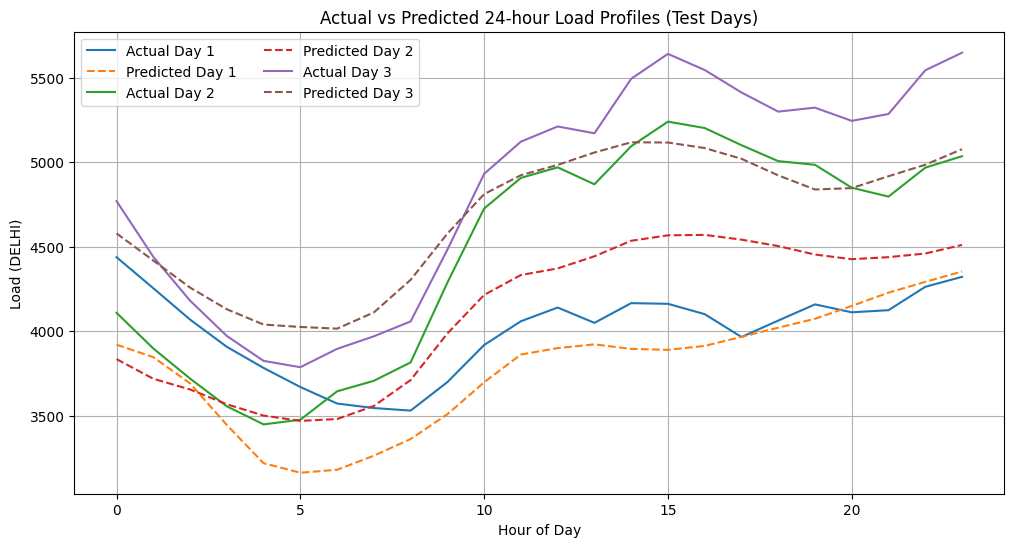

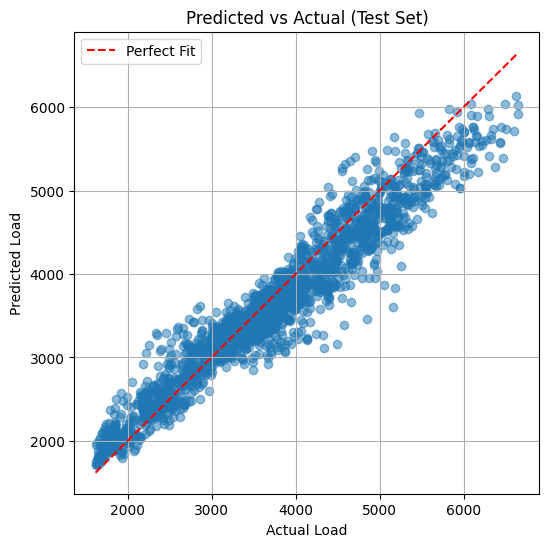

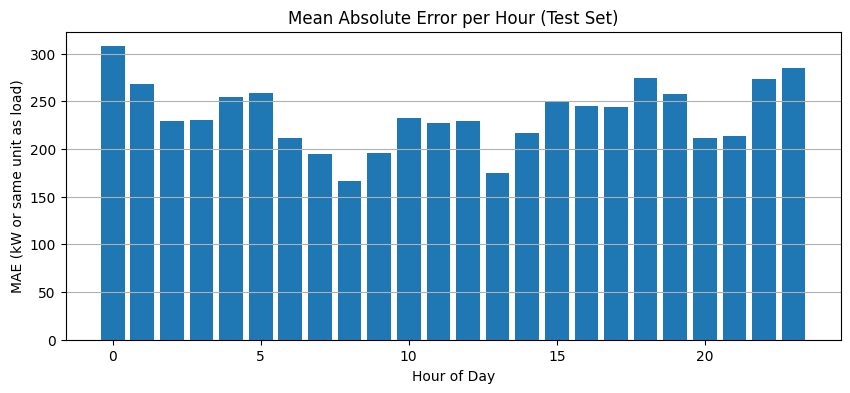

In [ ]:
# ===============================
# Visualization of Test Predictions
# ===============================

import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Plot a few test days (actual vs predicted)
n_show = min(3, y_test_inv.shape[0])   # number of days to plot
hours = np.arange(24)

plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.plot(hours, y_test_inv[i], label=f'Actual Day {i+1}')
    plt.plot(hours, y_pred_inv[i], '--', label=f'Predicted Day {i+1}')

plt.xlabel('Hour of Day')
plt.ylabel('Load (DELHI)')
plt.title('Actual vs Predicted 24-hour Load Profiles (Test Days)')
plt.legend(ncol=2)
plt.grid(True)
plt.show()

# 2️⃣ Scatter plot: predicted vs actual (all test hours)
plt.figure(figsize=(6,6))
plt.scatter(y_test_inv.flatten(), y_pred_inv.flatten(), alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()],
         [y_test_inv.min(), y_test_inv.max()],
         'r--', label='Perfect Fit')
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.title('Predicted vs Actual (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ Hour-wise MAE (already computed as `hourly_mae`)
plt.figure(figsize=(10,4))
plt.bar(hours, hourly_mae)
plt.xlabel('Hour of Day')
plt.ylabel('MAE (kW or same unit as load)')
plt.title('Mean Absolute Error per Hour (Test Set)')
plt.grid(True, axis='y')
plt.show()


In [ ]:
# Plot daily mean load (actual vs predicted)
actual_daily_mean = y_test_inv.mean(axis=1)
pred_daily_mean = y_pred_inv.mean(axis=1)




In [ ]:
# Plot daily mean load (actual vs predicted)
actual_daily_mean_on_train = y_train_inv.mean(axis=1)
pred_daily_meanon_train = y_pred_inv_ontrain.mean(axis=1)
pred_daily_meanon_train.shape,actual_daily_mean_on_train.shape

((422,), (422,))

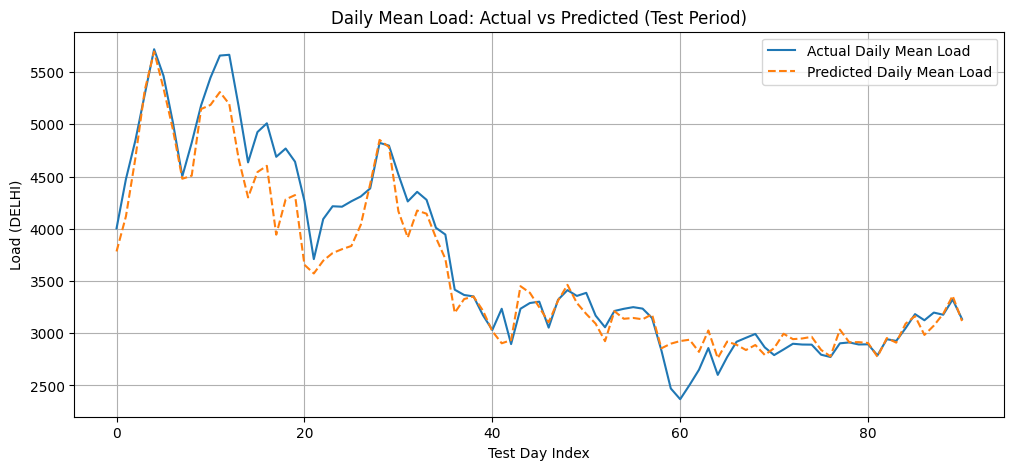

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(actual_daily_mean, label='Actual Daily Mean Load')
plt.plot(pred_daily_mean, label='Predicted Daily Mean Load', linestyle='--')
plt.title('Daily Mean Load: Actual vs Predicted (Test Period)')
plt.xlabel('Test Day Index')
plt.ylabel('Load (DELHI)')
plt.legend()
plt.grid(True)
plt.show()


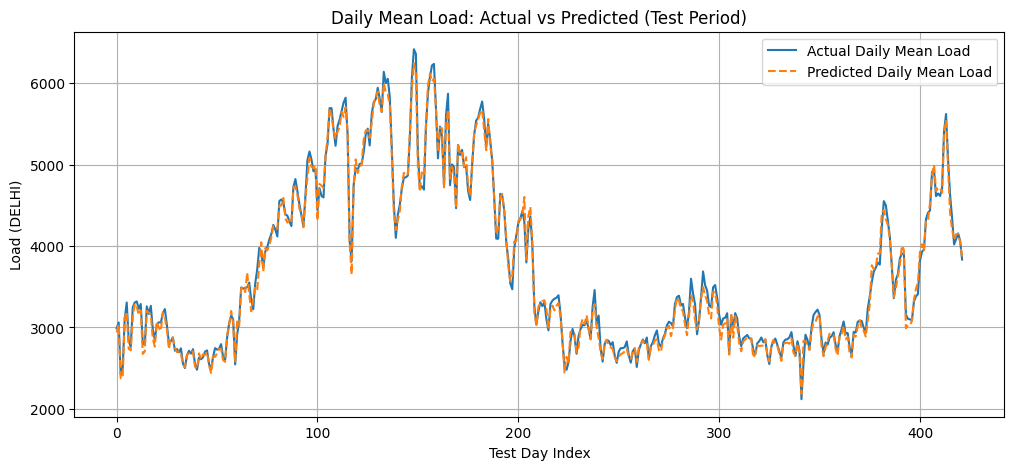

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(actual_daily_mean_on_train, label='Actual Daily Mean Load')
plt.plot(pred_daily_meanon_train, label='Predicted Daily Mean Load', linestyle='--')
plt.title('Daily Mean Load: Actual vs Predicted (Test Period)')
plt.xlabel('Test Day Index')
plt.ylabel('Load (DELHI)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
errors = np.mean(np.abs(y_test_inv - y_pred_inv), axis=1)

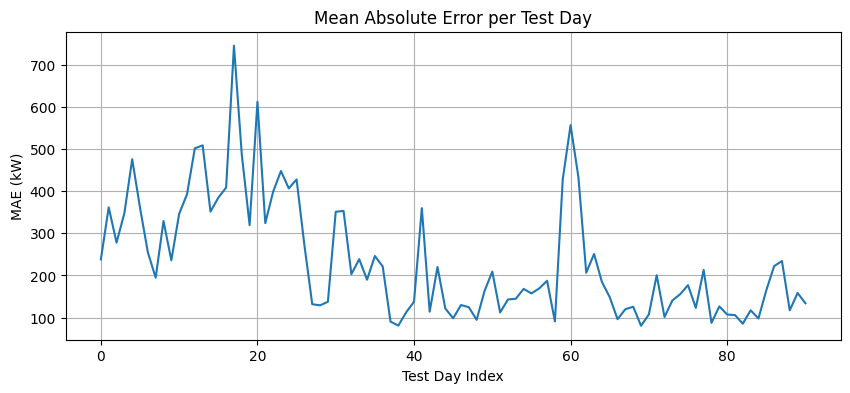

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(errors)
plt.title('Mean Absolute Error per Test Day')
plt.xlabel('Test Day Index')
plt.ylabel('MAE (kW)')
plt.grid(True)
plt.show()


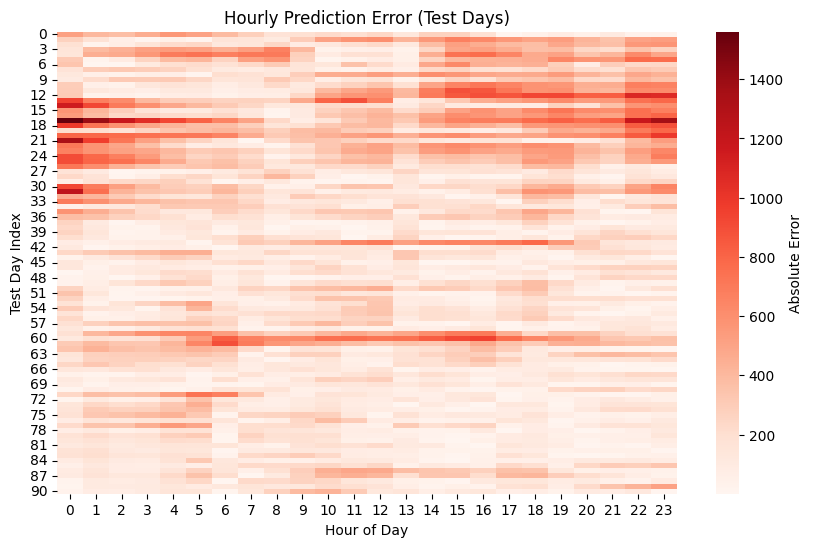

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(np.abs(y_test_inv - y_pred_inv), cmap='Reds', cbar_kws={'label': 'Absolute Error'})
plt.title('Hourly Prediction Error (Test Days)')
plt.xlabel('Hour of Day')
plt.ylabel('Test Day Index')
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_daily_mean, pred_daily_mean)
rmse = np.sqrt(mean_squared_error(actual_daily_mean, pred_daily_mean))
mape = np.mean(np.abs((actual_daily_mean - pred_daily_mean) / actual_daily_mean)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 167.00
RMSE: 236.55
MAPE: 4.42%


In [ ]:
# import os
# import datetime
# import joblib
# import pickle
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # ============================================================
# # 1️⃣ Create dated output folder
# # ============================================================
# base_save_dir = "/content/drive/MyDrive/Model/lstm_saved"
# os.makedirs(base_save_dir, exist_ok=True)

# timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# save_dir = os.path.join(base_save_dir, f"model_run_{timestamp}")
# os.makedirs(save_dir, exist_ok=True)

# print(f"📂 Created save directory:\n{save_dir}\n")

# # ============================================================
# # 2️⃣ Save TensorFlow model (H5)
# # ============================================================
# model_h5_path = os.path.join(save_dir, f"lstm_forecast_model_{timestamp}.h5")
# model.save(model_h5_path)
# print(f"✅ Saved Keras model (.h5): {model_h5_path}")

# # ============================================================
# # 3️⃣ Save model as Pickle and Joblib
# # ============================================================
# # Warning: Pickle/Joblib are not TF-native, but work for small models
# pickle_model_path = os.path.join(save_dir, f"lstm_model_{timestamp}.pkl")
# joblib_model_path = os.path.join(save_dir, f"lstm_model_{timestamp}.joblib")

# with open(pickle_model_path, "wb") as f:
#     pickle.dump(model, f)
# joblib.dump(model, joblib_model_path)

# print(f"✅ Saved model as Pickle: {pickle_model_path}")
# print(f"✅ Saved model as Joblib: {joblib_model_path}")

# # ============================================================
# # 4️⃣ Save Scalers (both pickle + joblib)
# # ============================================================
# feature_scaler_pkl = os.path.join(save_dir, f"feature_scaler_{timestamp}.pkl")
# target_scaler_pkl = os.path.join(save_dir, f"target_scaler_{timestamp}.pkl")
# feature_scaler_joblib = os.path.join(save_dir, f"feature_scaler_{timestamp}.joblib")
# target_scaler_joblib = os.path.join(save_dir, f"target_scaler_{timestamp}.joblib")

# # Joblib save
# joblib.dump(feature_scaler, feature_scaler_joblib)
# joblib.dump(target_scaler, target_scaler_joblib)

# # Pickle save
# with open(feature_scaler_pkl, "wb") as f:
#     pickle.dump(feature_scaler, f)
# with open(target_scaler_pkl, "wb") as f:
#     pickle.dump(target_scaler, f)

# print("✅ Saved feature & target scalers (Pickle + Joblib)")

# # ============================================================
# # 5️⃣ Compute metrics on test data
# # ============================================================
# y_test_pred_scaled = model.predict(X_test)
# y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).reshape(y_test.shape)
# y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# mae = mean_absolute_error(y_test_inv.flatten(), y_test_pred.flatten())
# rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_test_pred.flatten()))
# mape = np.mean(np.abs((y_test_inv - y_test_pred) / y_test_inv)) * 100

# metrics_summary = {
#     "testing": {"MAE": float(mae), "RMSE": float(rmse), "MAPE": float(mape)},
#     "model_explanation": {
#         "architecture": "LSTM(128) + Dropout(0.2) + Dense(64, relu) + Dense(24)",
#         "input_features": [
#             'temperature (degC)', 'dewpoint_temperature (degC)',
#             'relative_humidity (0-1)', 'wind_speed (m/s)', 'wind_direction (deg)',
#             'total_cloud_cover (0-1)', 'total_precipitation (mm of water equivalent)',
#             'is_holiday', 'hour', 'day', 'month', 'year', 'dayofweek', 'is_weekend'
#         ],
#         "output": "24-hour ahead load forecast for DELHI",
#         "training_samples": int(len(X_train)),
#         "testing_samples": int(len(X_test)),
#         "scalers": {"feature_scaler": "StandardScaler", "target_scaler": "StandardScaler"}
#     }
# }

# # Save metrics
# pickle_metrics_path = os.path.join(save_dir, "model_metrics.pkl")
# joblib_metrics_path = os.path.join(save_dir, "model_metrics.joblib")

# with open(pickle_metrics_path, "wb") as f:
#     pickle.dump(metrics_summary, f)
# joblib.dump(metrics_summary, joblib_metrics_path)

# print(f"✅ Metrics saved: {pickle_metrics_path} & {joblib_metrics_path}")

# # ============================================================
# # 6️⃣ Display summary
# # ============================================================
# print("\n📁 Files saved successfully:")
# for f in sorted(os.listdir(save_dir)):
#     print("  •", f)

# print(f"\n✅ All components stored for run: {timestamp}")


In [ ]:
y_test_inv[-1]

array([2079.8925  , 1848.073333, 1735.421667, 1684.695   , 1753.41    ,
       2098.961667, 2839.090833, 3518.071667, 3952.24    , 4255.373333,
       4451.368333, 4345.571667, 4074.565   , 3627.694167, 3531.3775  ,
       3410.705833, 3353.6675  , 3587.335   , 3692.988333, 3552.176667,
       3327.534167, 3098.9325  , 2781.435833, 2667.26    ])

In [ ]:
sample_day_data = X_test[-1]
sample_day_data[0]

array([0.0000e+00, 3.0000e+01, 1.2000e+01, 2.0230e+03, 5.0000e+00,
       1.1440e+01, 1.0910e+01, 9.7000e-01, 1.6400e+00, 3.4882e+02,
       2.1000e-01, 0.0000e+00, 0.0000e+00, 1.0000e+00])

In [ ]:
sample_features_for_day = X_test_scaled[-1]
sample_features_for_day.shape

(24, 14)

NameError: name 'predict_day_loads_from_df' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sample input features for one day (first 5 rows):
    hour  day  month    year  dayofweek  temperature (degC)  \
0     0  2.0   12.0  2023.0        5.0               17.49   
1     1  2.0   12.0  2023.0        5.0               16.88   
2     2  2.0   12.0  2023.0        5.0               16.80   
3     3  2.0   12.0  2023.0        5.0               15.36   
4     4  2.0   12.0  2023.0        5.0               15.33   

   dewpoint_temperature (degC)  relative_humidity (0-1)  wind_speed (m/s)  \
0                        16.38                     0.93              1.70   
1                        16.06                     0.95              1.66   
2                        16.06                     0.95              1.67   
3                        15.00                     0.98              1.58   
4                        15.17                     0.99              1.56   

   wind_direction (deg)  total_cloud_cover (0-1)  \
0                326.12

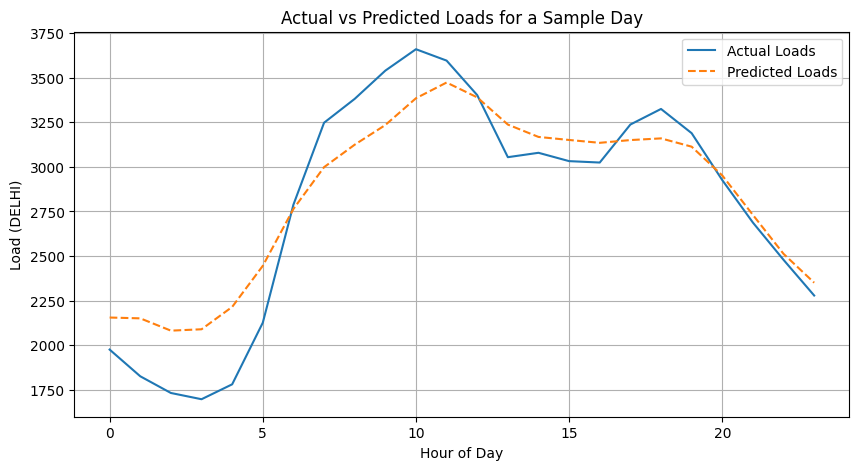

In [ ]:

offset=-16

sample_day_data = X_test[offset] # Get the last day from the inverse transformed test data
sample_features_for_day = X_test_scaled[-60]



# Create a DataFrame for a sample day, mimicking the structure used for training
sample_df_day = pd.DataFrame(sample_day_data, columns=feature_cols)

# Ensure 'hour' column is correct (assuming 0-23 for a day)
sample_df_day['hour'] = np.arange(24)

# Make a prediction for this sample day
predicted_loads_for_sample_day = predict_day_loads_from_df(
    model, feature_scaler, target_scaler, sample_df_day
)


print("Sample input features for one day (first 5 rows):\n", sample_df_day.head())
print("\nPredicted 24-hour loads for the sample day:\n", predicted_loads_for_sample_day)

# You can compare with the actual values if you have them for this specific day
# For example, if this was the last day in y_test:
sample_day_data = X_test[offset] # Get the last day from the inverse transformed test data
actual_loads_for_sample_day = y_test_inv[offset]
print("\nActual 24-hour loads for the sample day:\n", actual_loads_for_sample_day)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(24), actual_loads_for_sample_day, label='Actual Loads')
plt.plot(np.arange(24), predicted_loads_for_sample_day, '--', label='Predicted Loads')
plt.xlabel('Hour of Day')
plt.ylabel('Load (DELHI)')
plt.title('Actual vs Predicted Loads for a Sample Day')
plt.legend()
plt.grid(True)
plt.show()